#Combinando Classificadores -- *Bagging*, *Boosting* e Florestas Aleatórias

Fontes da aula de hoje:
1. Capítulos 22 do *Livro Data Mining and Machine Learning: Fundamental Concepts and Algorithms* (https://dataminingbook.info/book_html/)

3. Várias páginas da documentação da ``scikit-learn``

# Introdução

## Nosso problema de interesse

Dados $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$, a tarefa de classificação consiste em encontrar um modelo $f$ que aprenda dos vetores de características os rótulos.

Há dois requisitos principais:

1. Se $(\mathbf{x}, y) \in D$, então $f(\mathbf{x}) = y$ com alta probabilidade.

2. A função aprendida deve ser **generalizável**. Se um novo $\mathbf{x}$ não pertencente ao conjunto $D$ for observado, deseja-se também que $f(\mathbf{x})$ seja o rótulo correto de $\mathbf{x}$ com alta probabilidade.

## Como combinar classificadores já treinados?

What?

### Vamos começar com um experimento simples

O código abaixo gera um bit aleatório. O bit assume valor 1 com probabilidade $p$ e valor 0 com probabilidade $1 - p$.

In [ ]:
import random
import numpy as np

def random_bit(p = 0.5):
  if random.random() < p:
    return 1
  return 0

Se gerarmos $n$ bits, é esperado que tenhamos $np$ bits com valor 1.

In [ ]:
n = 1001    # número de bits da sequência
p = 0.6    # probabilidade bit 1

bits = [random_bit(p) for i in range(n)]
print(np.mean(bits))

0.5974025974025974


Repetindo o código acima várias vezes ($N = 100$ vezes), podemos observar a convergência para $np$.

In [ ]:
average = 0
N = 100
for i in range(N):
  bits = [random_bit(p) for i in range(n)]
  average += np.mean(bits) / N
print(average)

0.5974125874125876


E qual a chance/probabilidade de termos mais do que $\frac{n}{2}$ bits com valor 1?

In [ ]:
moreThanHalf = 0
N = 10000
for i in range(N):
  bits = [random_bit(p) for i in range(n)]
  if np.sum(bits) >= n / 2:
    moreThanHalf += 1
print(moreThanHalf / N)

1.0


*What is going on?* Alguma hipótese? Nós vamos abordar isso analiticamente já já.

### Vamos trazer isso para o contexto de classificação

Suponha um problema de classificação binária  e que você queira classificar um objeto $\mathbf{x}$. Você tem a sua disposição:
- $n$ classificadores já treinados, $C_1, \dots, C_n$

Sabe-se que:
- cada classificador, $C_i$, classifica $\mathbf{x}$ corretamente com probabilidade $p$
- $C_1, \dots, C_n$ são independentes

#### Na média, quantos classificadores vão acertar a classe de $\mathbf{x}$?

Espera-se que $np$ classificadores acertem.

Mas isso ajuda a gente a classificar $\mathbf{x}$?

Considere agora o seguinte classificador, $C$:
$$
C(\mathbf{x}) =
\begin{cases}
  1, \sum_{i=1}^nC_i(\mathbf{x}) \ge \frac{n}{2}\\
  0, \text{caso contrário}
\end{cases}
$$
Em outras palavras, $C$ representa o voto da maioria.

### Qual a chance de $C$ acertar a classe de $\mathbf{x}$?

$C$ acerta quando ao menos $\frac{n}{2}$ $C_i$'s acertam. Vamos transformar isso em números. Defina as seguinte variáveis indicadoras:
$$
I_i(\mathbf{x}) =
\begin{cases}
1, \text{se } C_i(\mathbf{x}) \text{ está correta}\\
0, \text{caso contrário}
\end{cases}
$$

Assim, $C(\mathbf{x})$ está correta se, e somente se, $\sum_{i = 1}^nI_i(\mathbf{x}) \ge \frac{n}{2}$.

Como cada $I_i(\mathbf{x})$ é uma variável aleatória com distribuição de *Bernoulli* e como as variáveis $I_i$'s são independentes, temos que a soma dessas variáveis indicadoras tem uma distribuição *Binomial* com parâmetros $n$ e $p$.

Dessa forma:
$$
\begin{eqnarray}
  P(C(\mathbf{x}) \text{ estar correta}) = P\left(\sum_{i=1}^nI_i(\mathbf{x}) \ge \frac{n}{2}\right) = \sum_{j = \frac{n}{2}}^n\binom{n}{j}p^j(1-p)^{n-j}
\end{eqnarray}
$$

Vejamos o que isso implica com alguns exemplos.

In [ ]:
from scipy.stats import binom
import math

# Essa função calcula a quantidade definida acima.
# Ver explicação em
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html
def succes_prob(n, p):
  return binom.sf(k = int(math.ceil(n / 2)) - 1, n = n, p = p)

In [ ]:
n = 100001
p = 0.51

print('Probabilidade de C(x) estar correta = ', succes_prob(n, p))

Probabilidade de C(x) estar correta =  0.9999999998735766


#### Em resumo

Se tivermos um grande número de classificadores independentes com chance de acerto superior a 50%, mesmo que medíocres, podemos combiná-los, atravéz do voto da maioria, e ter um resultado **consideravelmente melhor**.

# Questão de hoje

Como obter um número grande de classificadores que sejam **independentes** e tenham uma taxa de acerto **melhor que 50%**?

Na prática, encontrar um grande número de classificadores independentes é uma tarefa MUITO difícil. Vamos buscar então por um grande número de classificadores **não correlacionados**.

# *Bagging*

Termo formado pela junção das palavras *Bootstrap* e *aggregation*.

A ideia é criar um conjunto de classificadores pouco correlacionados fazendo uso de **amostragem com reposição**.

## Entrada

1. Um conjunto de treinamento $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$
2. Um algoritmo de aprendizado $A$
3. Um inteiro $K$

## Passo 1



Crie $K$ subamostras de $D$ através de amostragem com reposição. Denote as novas amostras por $D_1, \dots, D_K$

Essas amostras podem ter um tamanho menor que o conjunto de dados original.

## Passo 2

Obtenha um classificador, usando o algoritmo $A$, para cada subamostra. Defina por $A_i$ o classificador obtido com o conjunto $D_i$.

Repare que o treinamendo de cada classificador não depende em nada dos demais. Assim, o treinamento pode ser efetuado em paralelo.

## Na ``scikit-learn``

Abaixo, um exemplo que:
-  utiliza 101 classificadores KNN
- cada KNN deve ser treinado com todas as características (*features*) disponíveis
- e cada subamostra tem metade do tamanho da amostra original

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

bagging = BaggingClassifier(KNeighborsClassifier(), n_estimators = 101,
                            max_samples = 0.5, max_features = 1.0)

# *Boosting*

Novamente, a ideia é criar diferentes conjuntos de treinamento.

No entanto, tenta-se selecionar cuidadosamente as instâncias que são difíceis de serem corretamente classificadas.

Os seguintes passos sumarizam o método:
1. Um conjunto de treinamento $D_1$ é formado através de amostragem com reposição. Um classificador $C_1$ é treinado em $D_1$. A taxa de erro (em $D$) de $C_1$ é calculada;

2. As instâncias classificadas incorretamente por $C_1$ têm maior probabilidade de estarem na amostra $D_2$. Com $D_2$, um classificador $C_2$ é obtido e sua taxa de erro é calculada.

3. As instâncias classificadas incorretamente por $C_1$ ou por $C_2$ têm maior probabilidade de estarem na amostra $D_3$. Com $D_3$, um classificador $C_3$ é obtido e sua taxa de erro é calculada.

$\dots$

O processo acima é repetido $K$ vezes.
Veja que diferentemente de *bagging*, *boosting* não pode ser feito de forma paralela, uma vez que $D_i$ vai depender $C_1, \dots, C_{i-1}$.

O processo acima é uma descrição da ideia geral de *bosting* e pode ser instanciado de diversas maneiras.

Umas das variações mais populares é chamada *AdaBoost* (de *Adaptative Boosting*). Os detalhes estão disponíveis no Capítulo 22 do livro texto (não é complicado, mas são muitos detalhes...)

## *AdaBoost* na ``scikit-learn``

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = AdaBoostClassifier(KNeighborsClassifier(), n_estimators=101)

# *Random Forest*

A ideia é muito similar ao uso de *Bagging*, mas vamos fixar o classificador base como sendo **árvore de decisão** e vamos adicionar uma segunda fonte de aleatoriedade para tentar criar pouca correlação entre cada árvore.

A Figura abaixo ilusta o objetivo (fonte: https://en.wikipedia.org/wiki/Random_forest)

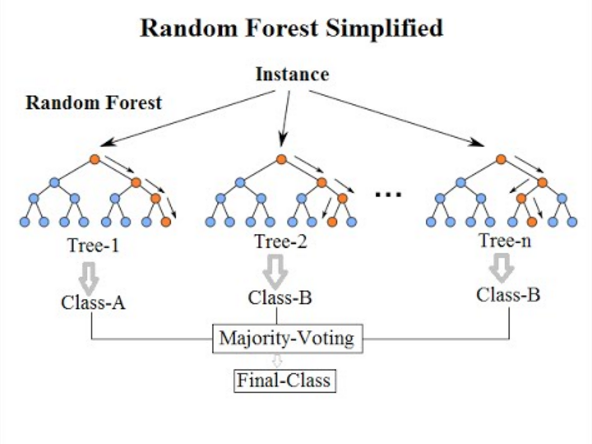

A ideia básica é descrita abaixo:

1. $K$ novos conjuntos de dados são formados utilizando a mesma estratégia que *Bagging*. Denote os novos conjuntos de treinamento por $D_1, \dots, D_K$

2. Uma árvore de decisão é treinada em cada conjunto $D_i$. No entanto, o processo de geração das árvore é ligeiramente modificado. Para cada teste (nó interno), um conjunto aleatório de $L$ características é considerado. Geralmente, usa-se $L = \sqrt{d}$, onde $d$ é o número total de características.

## *Random Forest* na ``scikit-learn``

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
X, y = load_breast_cancer(return_X_y = True, as_frame = True)
X

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators = 10000, min_samples_leaf = 1, n_jobs = -1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

# What is next?

Nas próximas aulas, discutiremos SVM.